In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
bike_data_raw = pd.read_csv('daily-bike-share.csv')
bike_data_raw

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,rentals
0,1,1/1/2011,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331
1,2,1/2/2011,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131
2,3,1/3/2011,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120
3,4,1/4/2011,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108
4,5,1/5/2011,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,12/27/2012,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247
727,728,12/28/2012,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644
728,729,12/29/2012,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159
729,730,12/30/2012,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364


In [2]:
bike_data = bike_data_raw.copy()
bike_data.drop(['instant', 'dteday', 'yr'], axis=1, inplace=True)
bike_data['difference_temp'] = (bike_data['atemp'] - bike_data['temp'])/bike_data['temp']
bike_data.drop(['atemp'], axis=1, inplace=True)
bike_data.head(5)

,season,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,rentals,difference_temp
0,1,1,0,6,0,2,0.344167,0.805833,0.160446,331,0.056537
1,1,1,0,0,0,2,0.363478,0.696087,0.248539,131,-0.026794
2,1,1,0,1,1,1,0.196364,0.437273,0.248309,120,-0.035439
3,1,1,0,2,1,1,0.200000,0.590435,0.160296,108,0.060610
4,1,1,0,3,1,1,0.226957,0.436957,0.186900,82,0.010191


In [3]:
numeric_features = ['temp', 'difference_temp', 'hum', 'windspeed']
categorical_features = ['season','mnth','holiday','weekday','workingday','weathersit']
target = 'rentals'

In [4]:
from sklearn.model_selection import KFold
cv = KFold(n_splits=5, shuffle=False)

Regresja wielomianowa wielu zmiennych

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler

# Podział na zmienne objaśniające i zmienną objaśnianą
X = bike_data[numeric_features+categorical_features].copy()
y = bike_data[target].copy()

# Podział na zbiór treningowy i testowy (taki sam podział co poprzednio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
numeric_transformer = Pipeline(steps=[
    ('logtransformer', PowerTransformer()),
    ('standardscaler', StandardScaler()),
    ('polynomialfeatures', PolynomialFeatures())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Tworzenie końcowego Pipeline, który będziemy trenować
final_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', ElasticNet())])

params = {'preprocessor__num__polynomialfeatures__degree': [1, 2, 3, 4, 5],
          'regressor__alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0],
          'regressor__l1_ratio': np.arange(0, 1.1, 0.1)}

final_polynomial_regression_gridsearch = GridSearchCV(final_pipeline,
                                                      params,
                                                      scoring='neg_mean_squared_error',
                                                      cv=cv)

final_polynomial_regression_gridsearch.fit(X_train, y_train)
final_polynomial_regression_model = final_polynomial_regression_gridsearch.best_estimator_

In [6]:
print("\nNajlepsze hiperparametry:", final_polynomial_regression_gridsearch.best_params_, "\n")


Najlepsze hiperparametry: {'preprocessor__num__polynomialfeatures__degree': 1, 'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.4} 



In [7]:
predictions_train = final_polynomial_regression_model.predict(X_train)
predictions_test = final_polynomial_regression_model.predict(X_test)

Regresja liniowa

In [8]:
from sklearn.linear_model import LinearRegression

X_lr = bike_data[['temp']].copy()
y = bike_data[target].copy()

X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lr, y, test_size=0.2, shuffle=False)

lr_model = LinearRegression()
lr_model.fit(X_train_lr, y_train_lr)

y_predict_train = lr_model.predict(X_train_lr)
y_predict_test = lr_model.predict(X_test_lr)

Współczynnik determinacji

In [9]:
from sklearn.metrics import r2_score
Train_R2_lin=r2_score(y_train_lr, y_predict_train)
Train_R2_poly=r2_score(y_train, predictions_train)

MAE - Mean Absolute Error

In [10]:
from sklearn.metrics import mean_absolute_error
Train_MAE_lin=mean_absolute_error(y_train_lr, y_predict_train)
Test_MAE_lin=mean_absolute_error(y_test_lr, y_predict_test)
Train_MAE_poly=mean_absolute_error(y_train, predictions_train)
Test_MAE_poly=mean_absolute_error(y_test, predictions_test)

MAPE - Mean Absolute Percentage Error

In [11]:
from sklearn.metrics import mean_absolute_percentage_error
Train_MAPE_lin=mean_absolute_percentage_error(y_train_lr, y_predict_train)
Test_MAPE_lin=mean_absolute_percentage_error(y_test_lr, y_predict_test)
Train_MAPE_poly=mean_absolute_percentage_error(y_train, predictions_train)
Test_MAPE_poly=mean_absolute_percentage_error(y_test, predictions_test)

MSE - Mean Squared Error

In [12]:
from sklearn.metrics import mean_squared_error
Train_MSE_lin=mean_squared_error(y_train_lr, y_predict_train)
Test_MSE_lin=mean_squared_error(y_test_lr, y_predict_test)
Train_MSE_poly=mean_squared_error(y_train, predictions_train)
Test_MSE_poly=mean_squared_error(y_test, predictions_test)

RMSE – Root Mean Squared Error

In [13]:
from math import sqrt
Train_RMSE_lin=sqrt(mean_squared_error(y_train_lr, y_predict_train))
Test_RMSE_lin=sqrt(mean_squared_error(y_test_lr, y_predict_test))
Train_RMSE_poly=sqrt(mean_squared_error(y_train, predictions_train))
Test_RMSE_poly=sqrt(mean_squared_error(y_test, predictions_test))

In [14]:
list_title=['Regression','R^2','Train_MAE','Test_MAE','Train_MAPE','Test_MAPE','Train_MSE','Test_MSE','Train_RMSE','Test_RMSE']
list_lin=['Linear',Train_R2_lin,Train_MAE_lin,Test_MAE_lin,Train_MAPE_lin,Test_MAPE_lin,Train_MSE_lin,Test_MSE_lin,Train_RMSE_lin,Test_RMSE_lin]
list_poly=['Polynomial',Train_R2_poly,Train_MAE_poly,Test_MAE_poly,Train_MAPE_poly,Test_MAPE_poly,Train_MSE_poly,Test_MSE_poly,Train_RMSE_poly,Test_RMSE_poly]
df= pd.DataFrame([list_lin,list_poly])
df.columns=list_title
df.set_index('Regression')

,R^2,Train_MAE,Test_MAE,Train_MAPE,Test_MAPE,Train_MSE,Test_MSE,Train_RMSE,Test_RMSE
Regression,,,,,,,,,
Linear,0.306179,404.833960,391.028794,0.966858,2.986493,317745.941243,397066.944718,563.689579,630.132482
Polynomial,0.701074,261.298427,348.585194,0.744319,0.859332,136897.752840,234195.931131,369.996963,483.937941


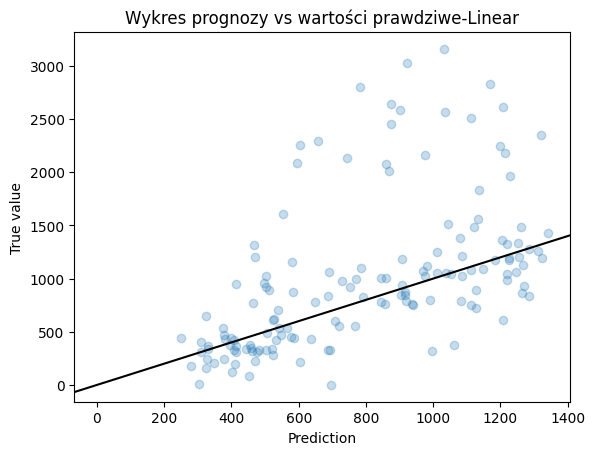

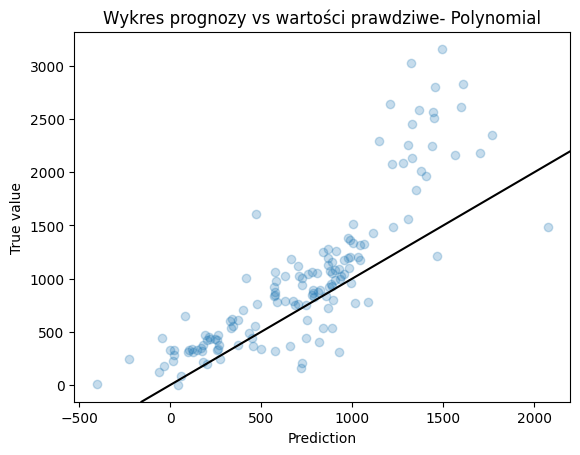

In [15]:
plt.scatter(x = y_predict_test, y = y_test_lr, alpha=0.25)
plt.axline((0, 0), slope=1,color='black')
plt.xlabel('Prediction')
plt.ylabel('True value')
plt.title(f'Wykres prognozy vs wartości prawdziwe-Linear')
plt.show()

plt.scatter(x = predictions_test, y = y_test, alpha=0.25)
plt.axline((0, 0), slope=1,color='black')
plt.xlabel('Prediction')
plt.ylabel('True value')
plt.title(f'Wykres prognozy vs wartości prawdziwe- Polynomial')
plt.show()

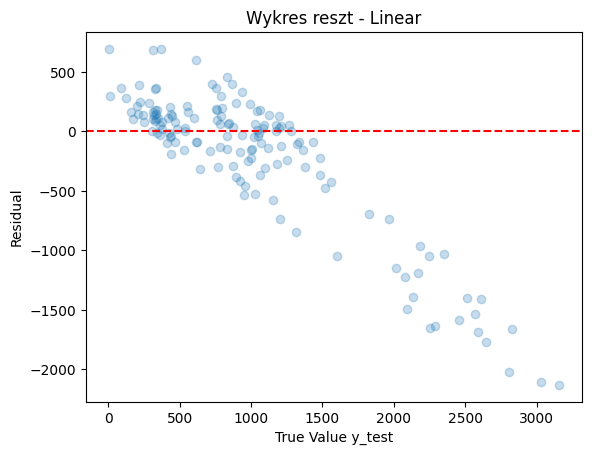

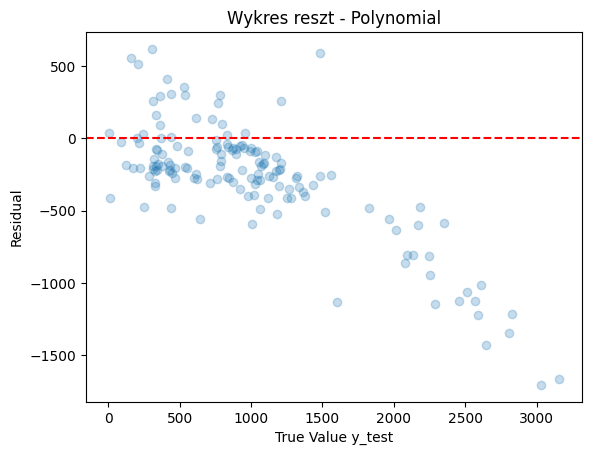

In [16]:
errors_lr = y_predict_test - y_test_lr
plt.scatter(x = y_test_lr, y = errors_lr, alpha=0.25)
plt.axhline(0, color="r", linestyle="--")
plt.xlabel('True Value y_test')
plt.ylabel('Residual')
plt.title(f'Wykres reszt - Linear')
plt.show()

errors = predictions_test - y_test
plt.scatter(x = y_test, y = errors, alpha=0.25)
plt.axhline(0, color="r", linestyle="--")
plt.xlabel('True Value y_test')
plt.ylabel('Residual')
plt.title(f'Wykres reszt - Polynomial')
plt.show()

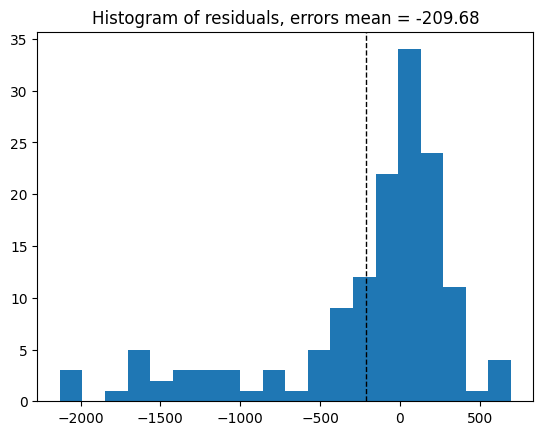

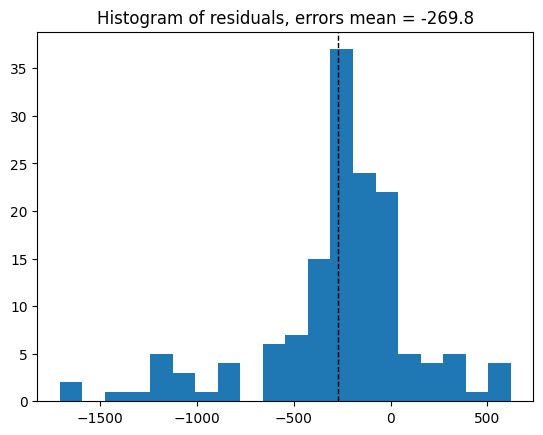

In [17]:
plt.hist(errors_lr, bins = 20)
plt.axvline(errors_lr.mean(), color='k', linestyle='dashed', linewidth=1)
plt.title(f'Histogram of residuals, errors mean = {np.round(errors_lr.mean(), 2)}')
plt.show()

plt.hist(errors, bins = 20)
plt.axvline(errors.mean(), color='k', linestyle='dashed', linewidth=1)
plt.title(f'Histogram of residuals, errors mean = {np.round(errors.mean(), 2)}')
plt.show()

Porównując metryki dla obydwu modeli, R^2 jest wyższy dla modelu Polynomial, co oznacza jego lepsze dopasowanie. Również błędy dla Polynomial Regression są znacząco niższe niż dla Linear Regression.
Wizualizacja prognozy vs wartości prawdziwej dla Polynomial pokazuje nam pukty bardziej zbliżone do lini trendu, w przeciwieńswie do Linear.
Na wykresach reszt punkty dla Polynomial znajdują się bliżej wartości Zerowej.